In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np

import obspy
from obspy import read, UTCDateTime, Stream, Trace

import xarray as xr
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.signal import spectrogram as sp
from scipy.signal import welch 

import os
import sys  
module_path = os.path.abspath(os.path.join('/Users/gilaverbuch/dev/WavePropagation/pypekeris'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.pypekeris.pypekeris import pekeris

# import webbrowser 
# import dask
# from dask import delayed, compute
# from dask.distributed import Client, LocalCluster


# cluster = LocalCluster(n_workers=3, threads_per_worker=2)
# client_dask = Client(cluster)
# webbrowser.open(client_dask.dashboard_link, new=2)

# Problem geometry

Two-layer liquid half space. Layer 1 (0<z<D) has a speed of sound c1. Layer 2 (z>D) has a speed of sound c2. Both source and receiver ar placed within the first layer. c2>c1. 

--------------------------------------------------------------------------------- z=0, pressure release surface

c1


*(0, z_s)




                                                           *(r,z)

--------------------------------------------------------------------------------- z=D, continuitu of P and w

c2

In [17]:
P = pekeris()
P._calc_parameters()
# P._print_parameters()

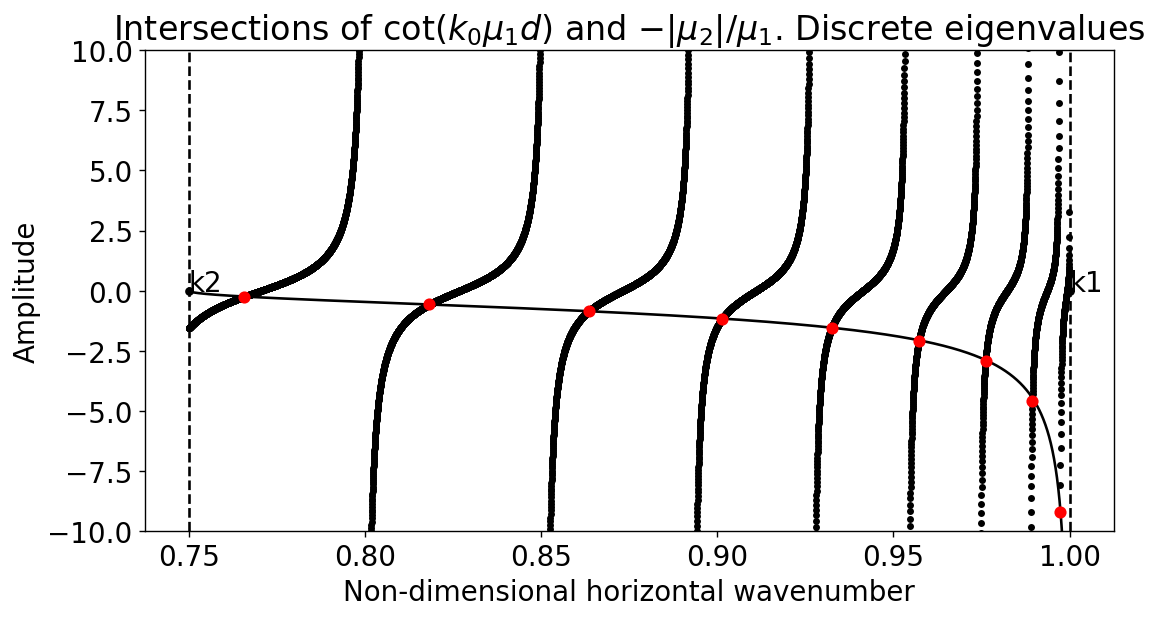

In [57]:
P._plot_discrete_modes()

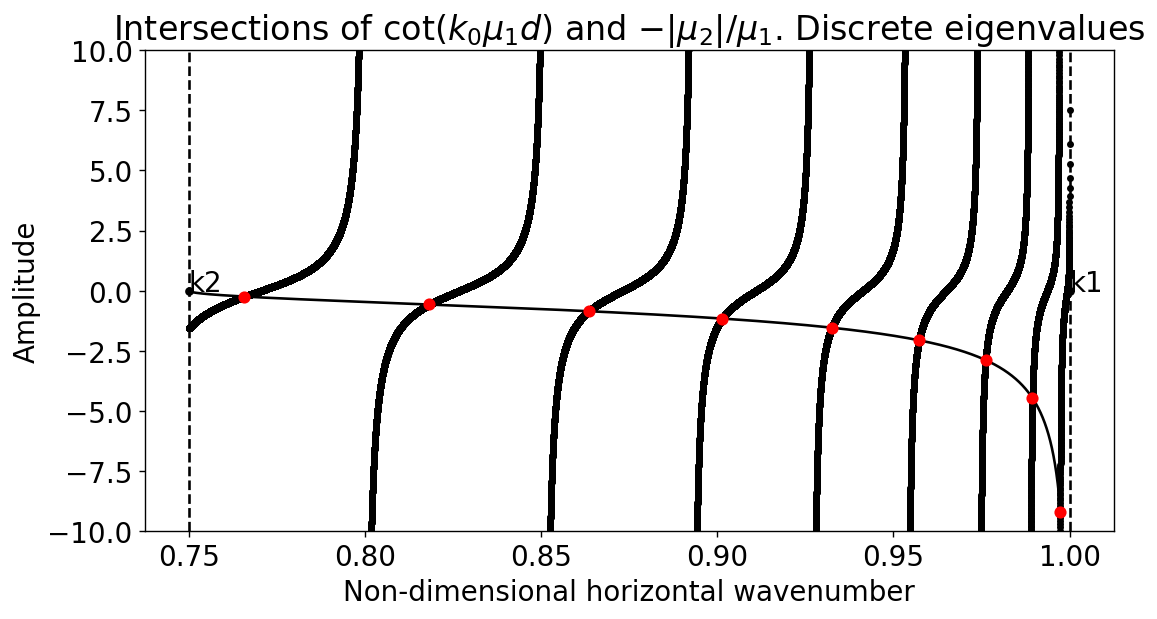

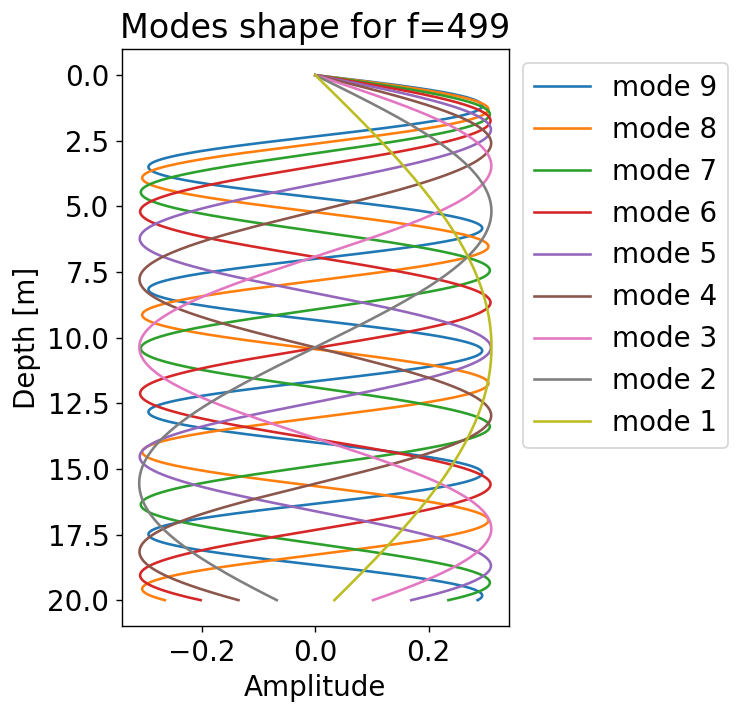

In [69]:
P.dz=0.0001
P.nq = 1e5
P._calc_parameters()
P._plot_discrete_modes()
P._plot_modes_shape()

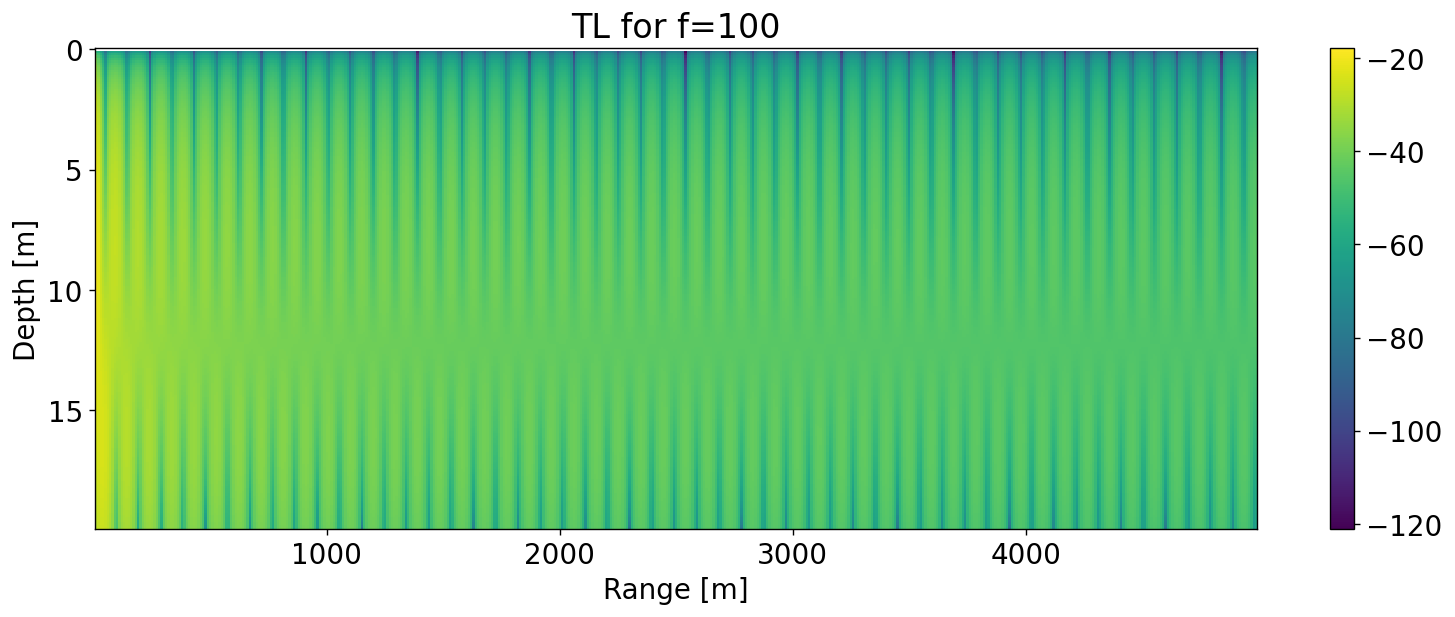

In [28]:
P.freq = 100
P.dz=0.1
P._calc_parameters()
P._calc_2D_field()
P._plot_TL()

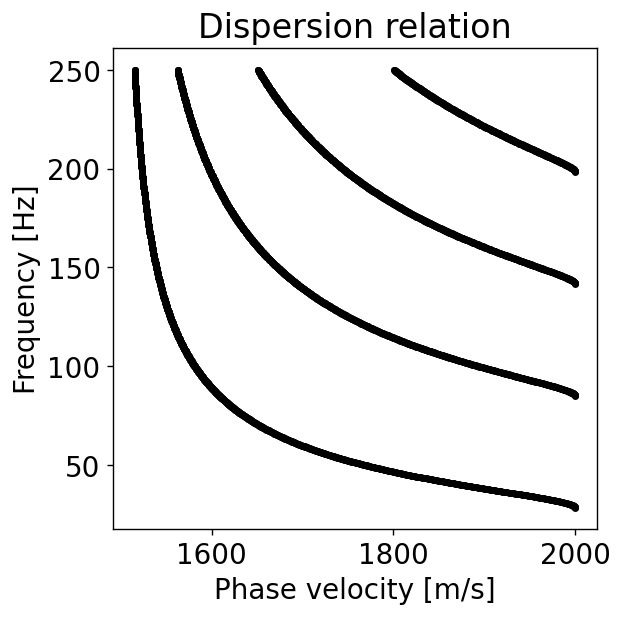

In [30]:
P.d = 20
P._plot_dispersion(fmax=250, df=0.1)

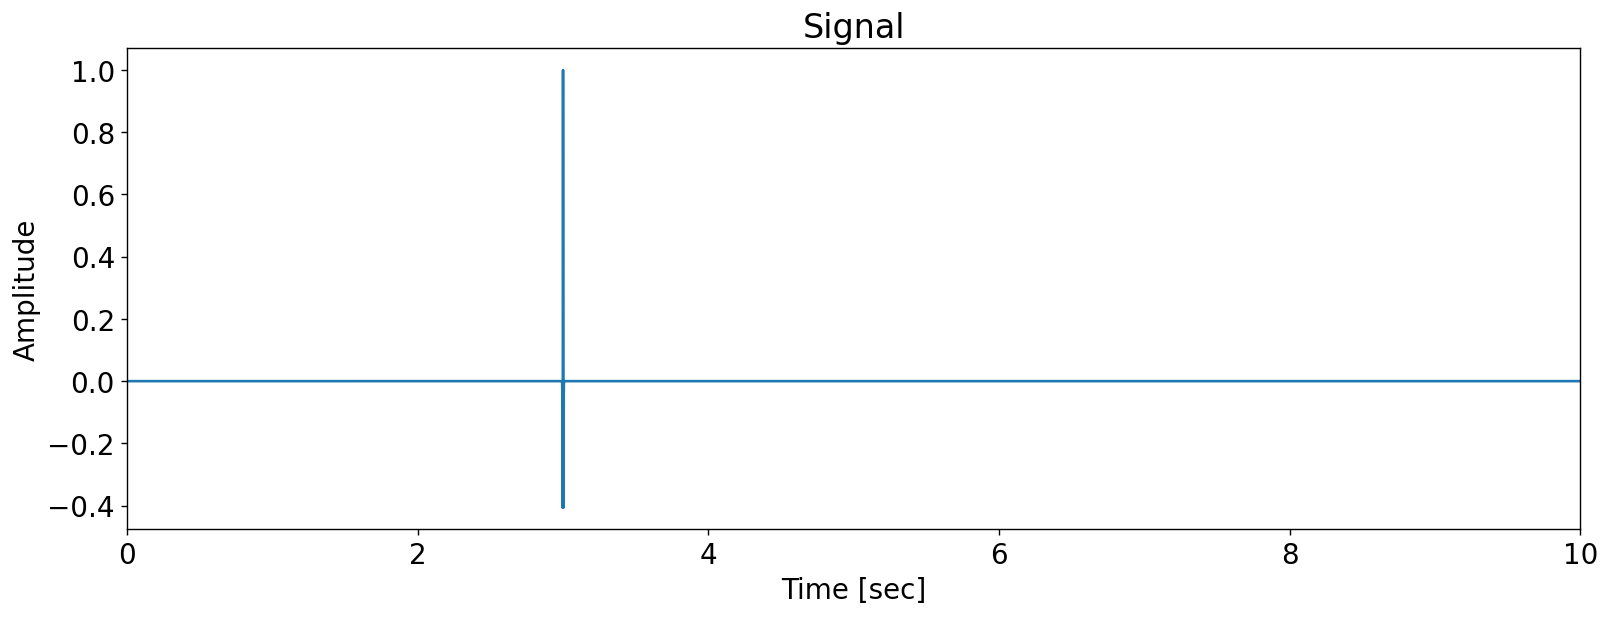

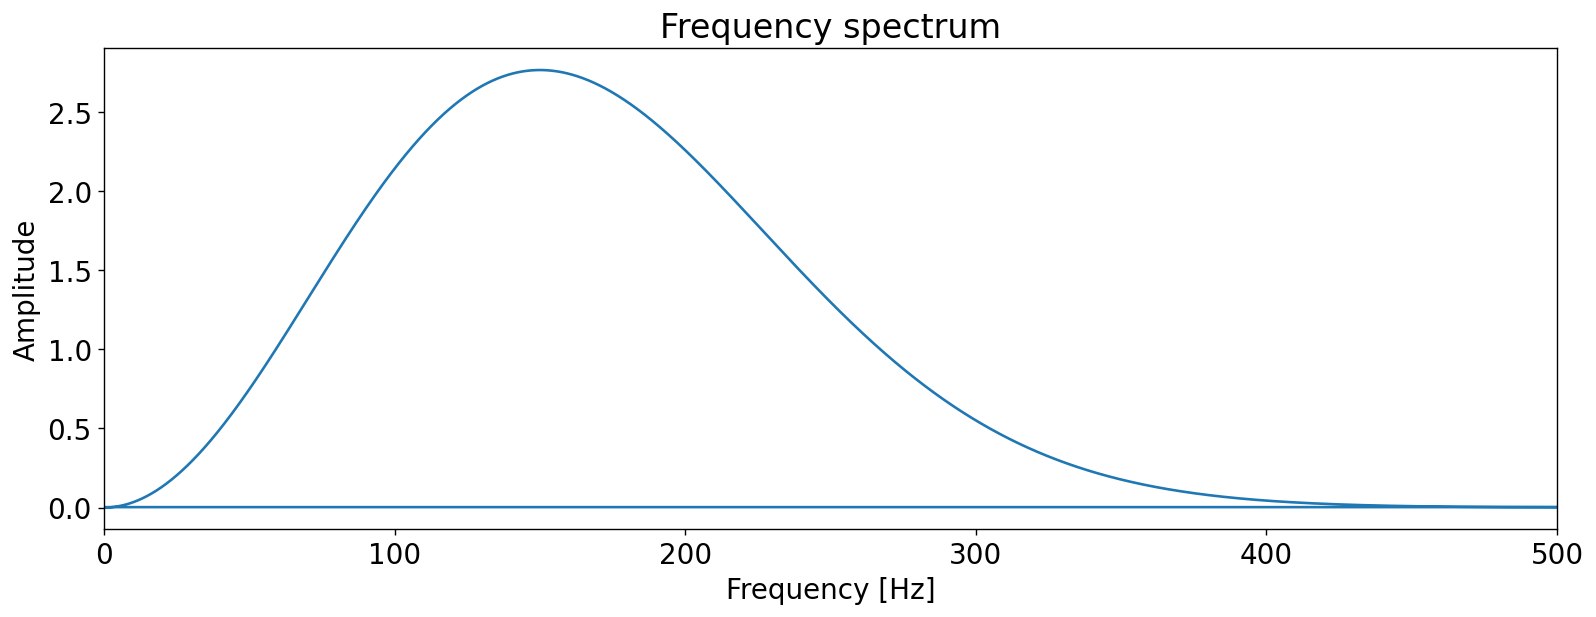

In [40]:
dt = 1e-3
l=int(200/dt)
time = np.arange(0,dt*l, dt)


fc = 150
t0 = 3
# Ricker
sig_ref = (1-2*(np.pi*fc*(time-t0))**2)*np.exp(-(np.pi*fc*(time-t0))**2)
# sig_ref = np.exp(-(np.pi*fc*(time-t0))**2)

l = len(sig_ref)
frequency = np.fft.fftfreq(l, dt)
df = frequency[1]
freq_ref = np.fft.fft(sig_ref)

plt.figure(figsize=(15,5))
plt.plot(time, sig_ref)
plt.xlim(0,10)
plt.title('Signal')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(frequency, np.abs(freq_ref))
plt.xlim(0,500)
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.show()

In [122]:
# df = 0.5
# fmin = 2
# fmax = 50
# frequency = np.arange(fmin, fmax, df)

pressure = np.zeros(frequency.size, dtype=np.complex64)

z_r = 5
r_r = 20000
fmax_idx = int(frequency.size/2)
for idx, f in enumerate(tqdm(frequency[1:fmax_idx])):
    P = pekeris(f=f, nq=5e4, dr=1, zs=10, d=20)
    P._calc_parameters()
    P._calc_field(r_rec=r_r, z_rec=z_r, num_mode=3)
    pressure[idx] = P.Phi*freq_ref[idx]



100%|█████████████████████████████████████████████████████| 99999/99999 [01:02<00:00, 1594.10it/s]


In [123]:
pressure_time = np.real(np.fft.fft(freq_ref*pressure*2))

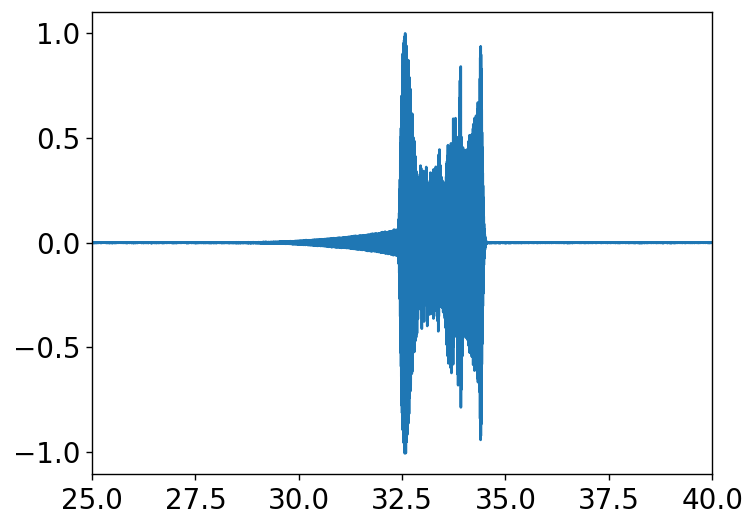

In [128]:
signal = np.roll(pressure_time, shift=25000)
signal = signal/np.max(signal)
plt.figure()
plt.plot(time, signal)
plt.xlim(25,40)
plt.show()

In [125]:
tr = Trace()
tr.stats.network = 'PK'
tr.stats.station = '00'
tr.stats.channel = 'FDH' # 
tr.stats.starttime = UTCDateTime.now()
tr.stats.sampling_rate = 1/time[1]
tr.stats.delta = time[1]
tr.stats.npts = time.size
tr.stats.calib = 1
tr.stats.units = 'Norm.'
tr.data = (signal/np.max(signal))

trc = tr.copy()
# tr.plot();
# trc.plot();

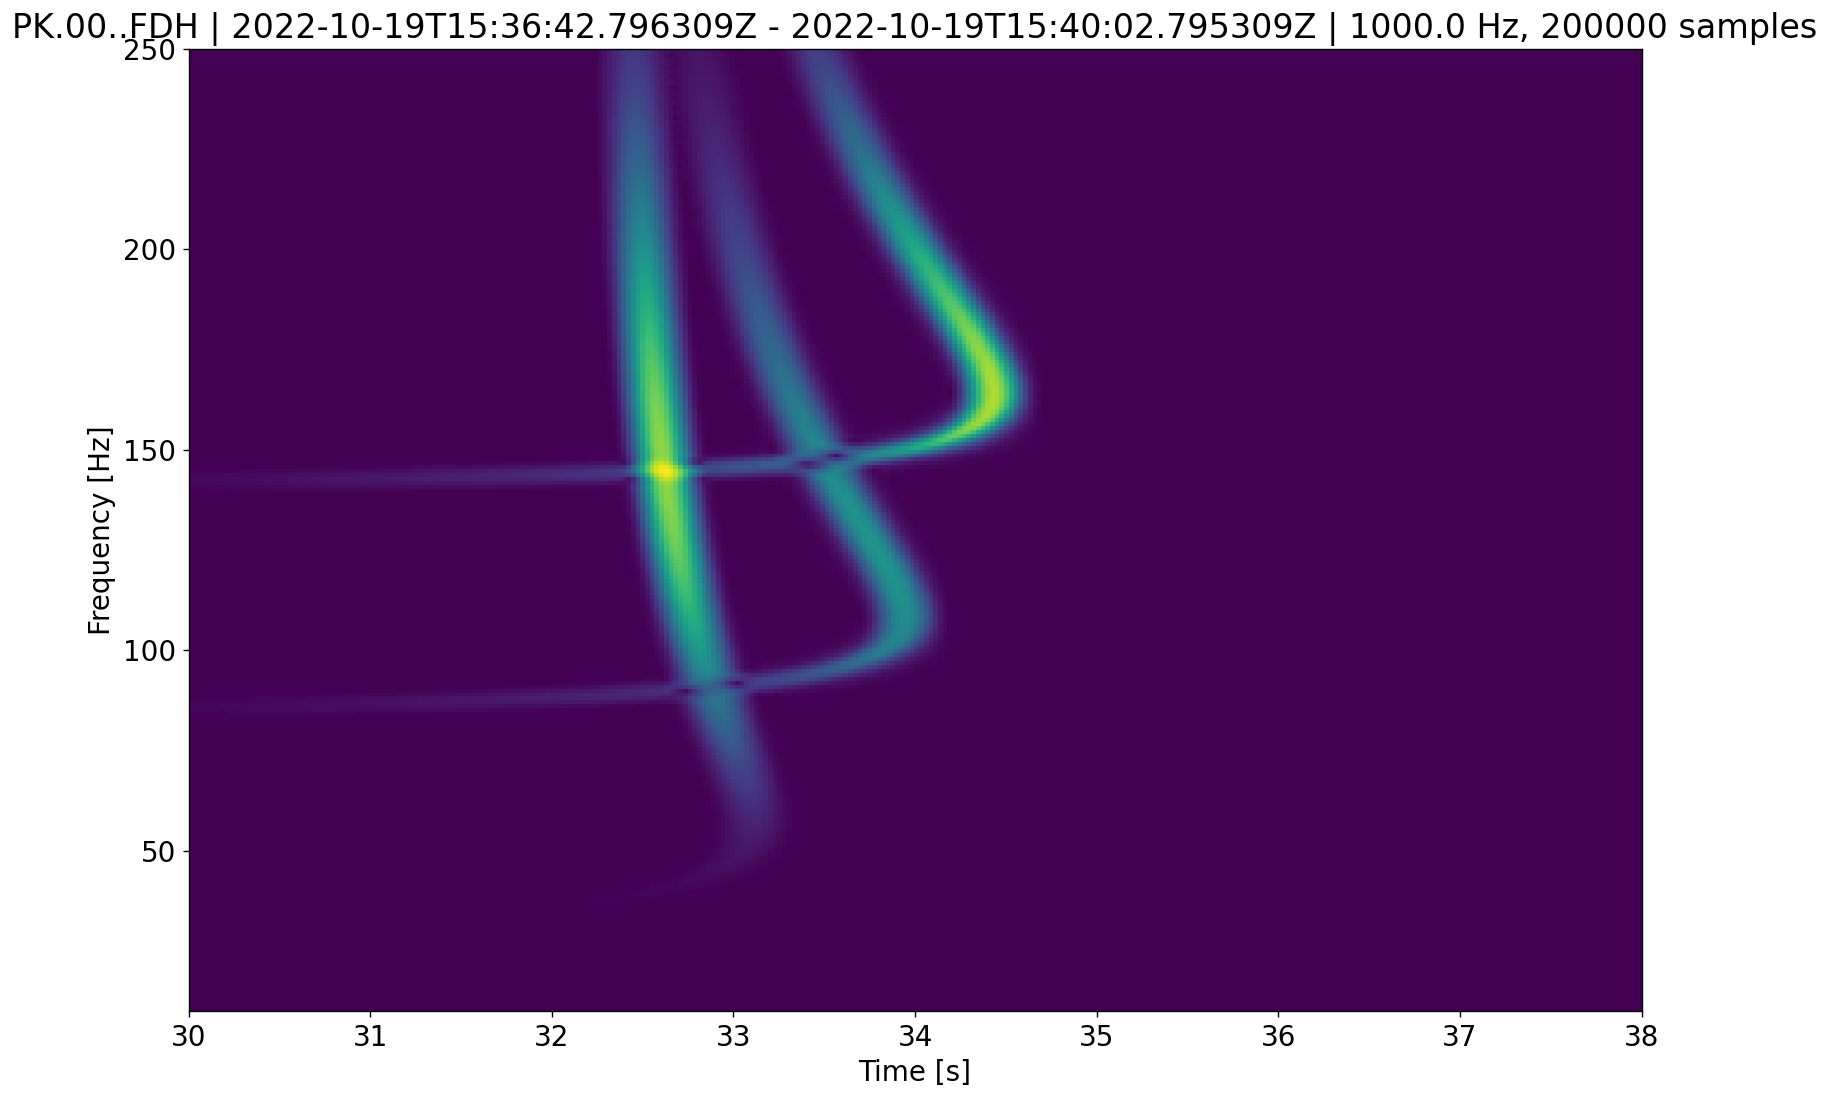

In [169]:
fig = trc.spectrogram(wlen=0.5, per_lap=0.95, mult=2, log=False, dbscale=False, show=False);
fig.set_figheight(10)
fig.set_figwidth(15)
plt.ylim(10,250)
plt.xlim(30,38)
plt.show()